# **Injury prediction based on journal data from the Dutch national men’s volleyball team**

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

In [2]:
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# from jupyter_datatables import init_datatables_mode
# init_datatables_mode()

In [4]:
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
    
    # % of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    
    # Print some summary information
    print(f" Dataframe has {df.shape[1]} columns.\n There are {mis_val_table_ren_columns.shape[0]} columns that have missing values.")
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

**Data Processing**

1. Player Jumps Dataset
(Height of all performed jumps)

In [8]:
jump_data = pd.read_csv('./data/Jumps.csv', sep=';')
jump_data['Date'] = pd.to_datetime(jump_data['Date'], format='%d-%m-%Y')
jump_data = jump_data[jump_data['HeightInCm'] != 0]
print(f"Shape of Players Jump dataset : {jump_data.shape}")
jump_data.head(5)

Shape of Players Jump dataset : (3589, 3)


,PlayerID,Date,HeightInCm
0,4,2018-05-10,70
1,4,2018-05-10,73
2,4,2018-05-10,55
3,4,2018-05-10,55
4,4,2018-05-10,56


In [9]:
def categorize_jump_height(height):
    if height < 45:
        return 'Low'
    elif height <= 65:
        return 'Average'
    else:
        return 'High'
    
jump_data['JumpCategory'] = jump_data['HeightInCm'].apply(categorize_jump_height)
jump_data.head(5)

,PlayerID,Date,HeightInCm,JumpCategory
0,4,2018-05-10,70,High
1,4,2018-05-10,73,High
2,4,2018-05-10,55,Average
3,4,2018-05-10,55,Average
4,4,2018-05-10,56,Average


In [10]:
jump_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3589 entries, 0 to 3618
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   PlayerID      3589 non-null   int64         
 1   Date          3589 non-null   datetime64[ns]
 2   HeightInCm    3589 non-null   int64         
 3   JumpCategory  3589 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 140.2+ KB


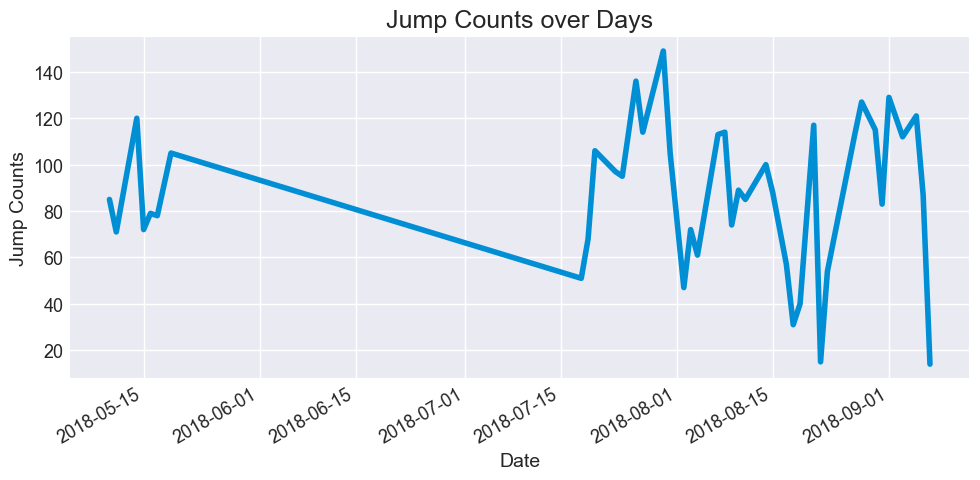

In [11]:
# jump_data.isnull().sum() #check null values
# jump_data.isna().sum() #check NaN values
plt.figure(figsize=(10,5), tight_layout=True)
colors = sns.color_palette('pastel')
jump_data.Date.value_counts().plot(kind='line')
plt.xlabel('Date')
plt.ylabel('Jump Counts')
plt.title('Jump Counts over Days')
plt.show()

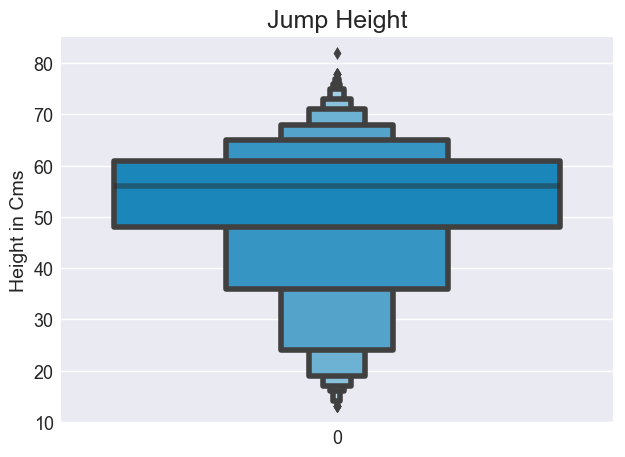

In [137]:
sns.boxenplot(jump_data['HeightInCm'])
plt.title('Jump Height')
plt.ylabel('Height in Cms')
plt.show()

In [13]:
jumps_daily = jump_data.groupby('Date').agg({
                                                'HeightInCm': ['count', 'sum', 'mean', 'max', 'min', 'std'],  # basic stats
                                                'JumpCategory': ['count']  # count of each category
                                            }).reset_index()

jumps_daily.columns = ['_'.join(col).strip() if col[1] else col[0] for col in jumps_daily.columns.values]
jump_categories_daily = jump_data.groupby(['Date', 'JumpCategory']).size().unstack(fill_value=0).reset_index()
jump_categories_daily.columns = ['Date', 'LowJumpCount', 'AverageJumpCount', 'HighJumpCount']
jumps_daily = pd.merge(jumps_daily, jump_categories_daily, on='Date', how='outer')

# If 'HeightInCm_std' has NaN values (which would occur if there's only one jump in a day), fill them with 0
# jumps_daily['HeightInCm_std'].fillna(0, inplace=True)

jumps_daily.columns = ['Date', 'JumpCount', 'SumJumpHeight', 'AvgJumpHeight', 'MaxJumpHeight', 'MinJumpHeight', 'StdJumpHeight', 'JumpCategory', 'LowJumpCount', 'AverageJumpCount', 'HighJumpCount']
jumps_daily.drop(columns=['JumpCategory'], inplace=True)

jumps_daily.head()

,Date,JumpCount,SumJumpHeight,AvgJumpHeight,MaxJumpHeight,MinJumpHeight,StdJumpHeight,LowJumpCount,AverageJumpCount,HighJumpCount
0,2018-05-10,85,4631,54.482353,76,13,15.240619,50,17,18
1,2018-05-11,71,4126,58.112676,77,13,12.036313,49,15,7
2,2018-05-14,120,6685,55.708333,76,15,10.099002,94,11,15
3,2018-05-15,72,3927,54.541667,73,20,12.805080,47,11,14
4,2018-05-16,79,4059,51.379747,72,18,14.967746,47,9,23


In [14]:
jumps_daily.isnull().sum()

Date                0
JumpCount           0
SumJumpHeight       0
AvgJumpHeight       0
MaxJumpHeight       0
MinJumpHeight       0
StdJumpHeight       0
LowJumpCount        0
AverageJumpCount    0
HighJumpCount       0
dtype: int64

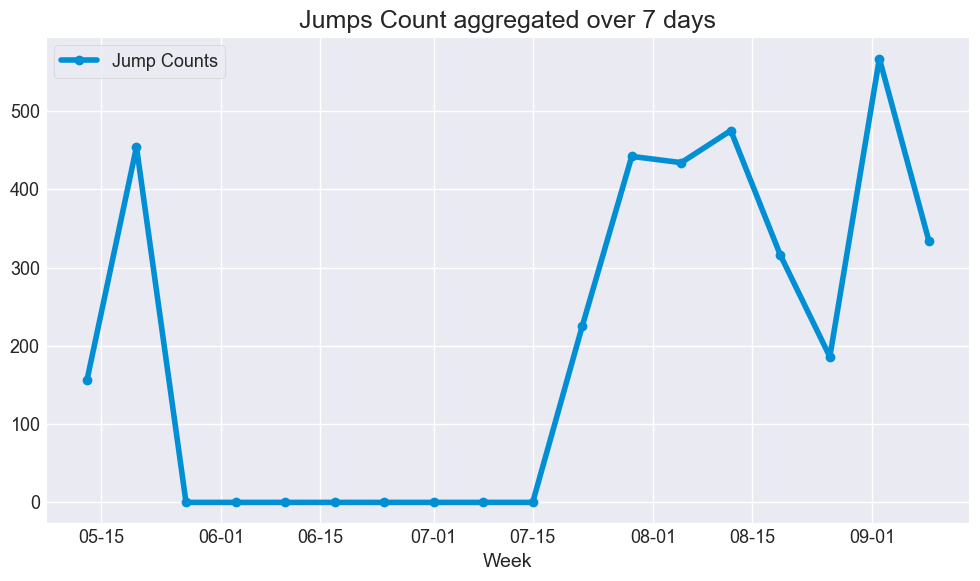

In [136]:
weekly_df = jumps_daily.copy()
weekly_df.set_index('Date', inplace=True)
weekly_df = weekly_df.resample('W').sum()

fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
ax.plot(weekly_df['JumpCount'], marker='o', linestyle='-', label='Jump Counts')
plt.xlabel('Week')
plt.grid(True)
plt.title('Jumps Count aggregated over 7 days')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True, ncol=3)
plt.legend()
plt.show()

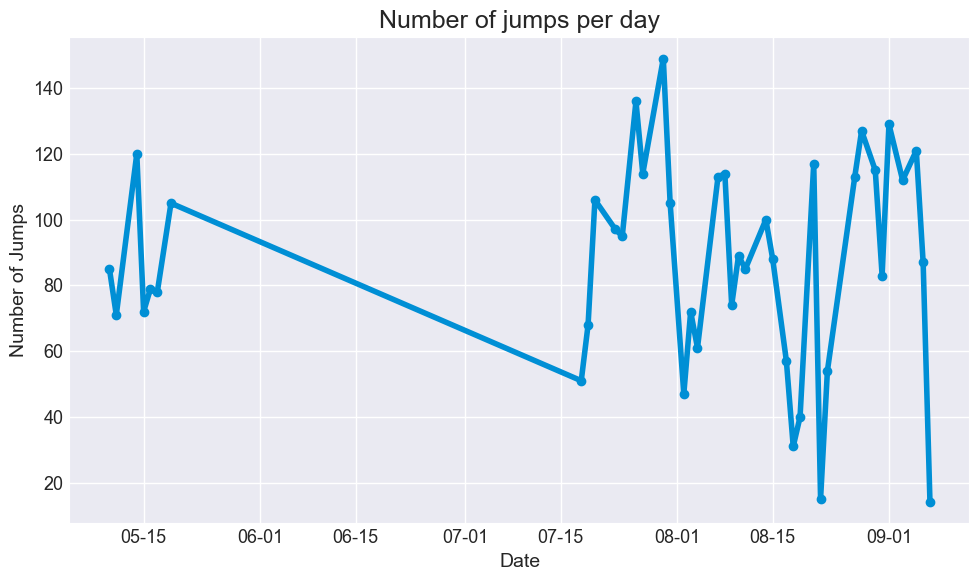

In [16]:
fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
ax.plot(jumps_daily.Date, jumps_daily['JumpCount'], marker='o')
# Changing the date format to MM-DD
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.title('Number of jumps per day')
plt.xlabel('Date')
plt.ylabel('Number of Jumps')
plt.grid(True)
plt.show()

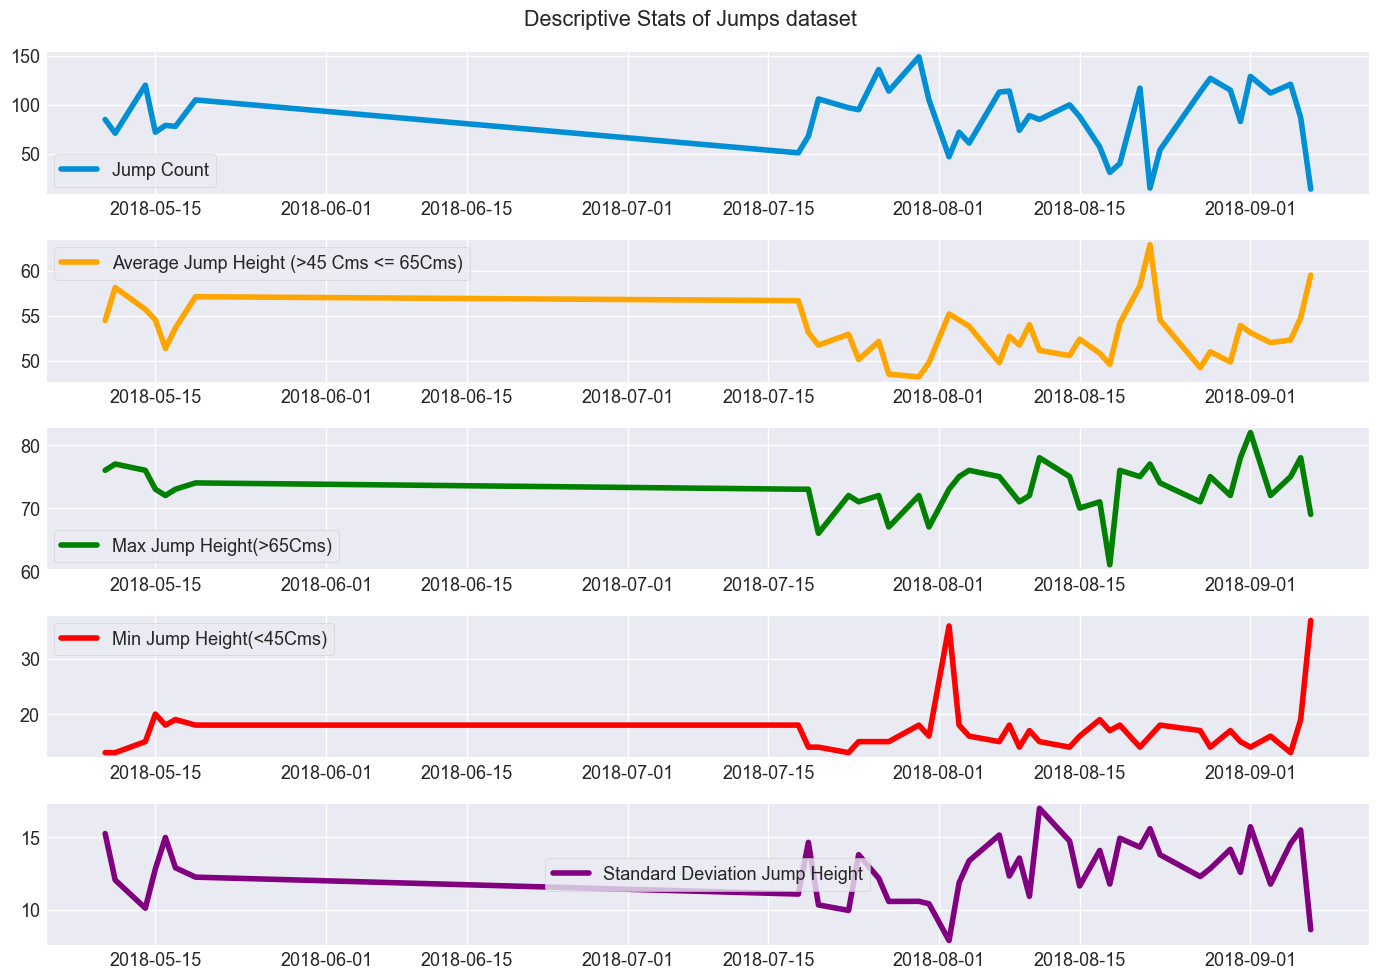

In [142]:
plt.figure(figsize=(14, 10), tight_layout=True)
plt.subplot(511)  # 5 rows, 1 column, plot 1

plt.suptitle('Descriptive Stats of Jumps dataset')
plt.plot(jumps_daily['Date'], jumps_daily['JumpCount'], label='Jump Count')
plt.legend()

plt.subplot(512, sharex = plt.gca())  # 5 rows, 1 column, plot 2
plt.plot(jumps_daily['Date'], jumps_daily['AvgJumpHeight'], label='Average Jump Height (>45 Cms <= 65Cms)', color='orange')
plt.legend()

plt.subplot(513, sharex = plt.gca())  # 5 rows, 1 column, plot 3
plt.plot(jumps_daily['Date'], jumps_daily['MaxJumpHeight'], label='Max Jump Height(>65Cms)', color='green')
plt.legend()

plt.subplot(514, sharex = plt.gca())  # 5 rows, 1 column, plot 4
plt.plot(jumps_daily['Date'], jumps_daily['MinJumpHeight'], label='Min Jump Height(<45Cms)', color='red')
plt.legend()

plt.subplot(515, sharex = plt.gca())  # 5 rows, 1 column, plot 5
plt.plot(jumps_daily['Date'], jumps_daily['StdJumpHeight'], label='Standard Deviation Jump Height', color='purple')
plt.legend()

plt.show()



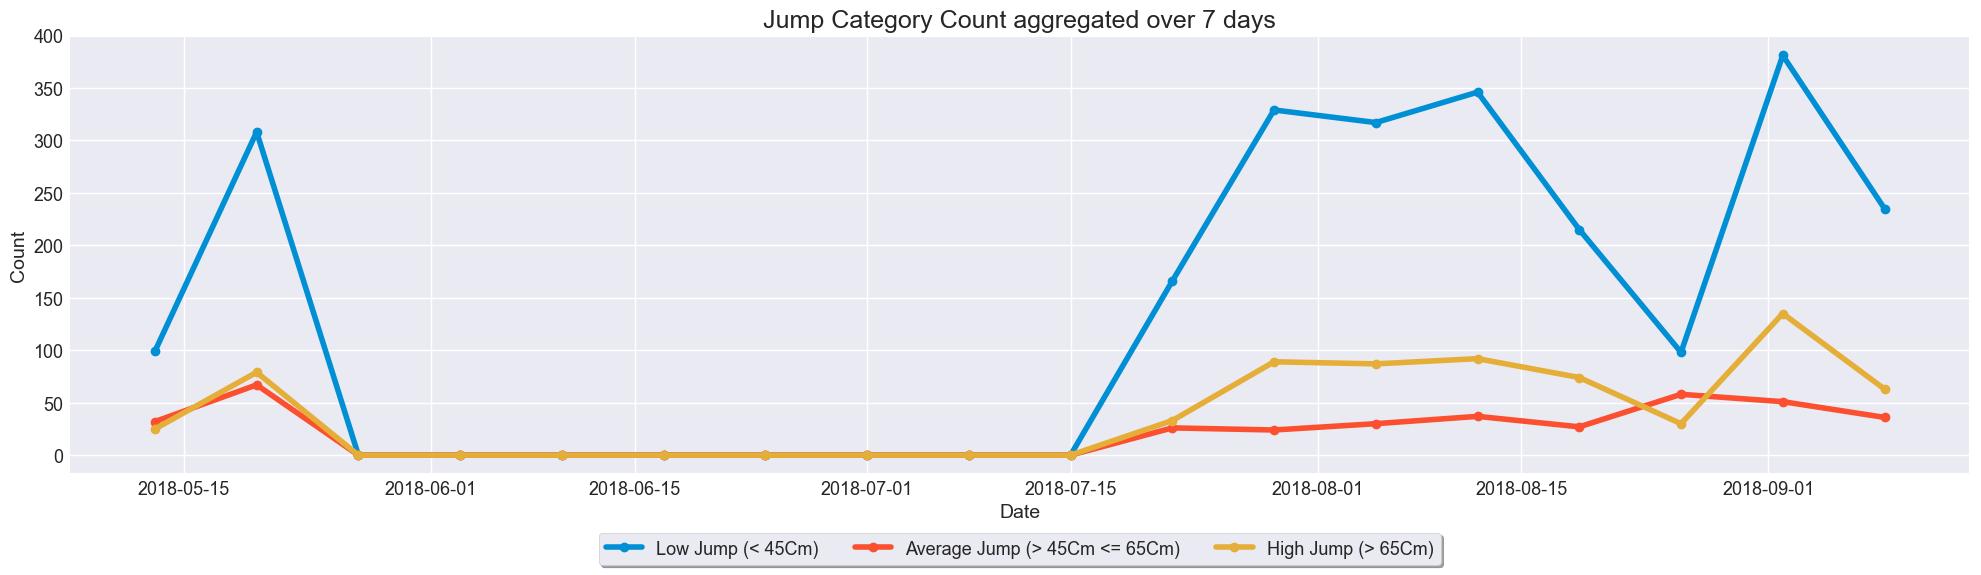

In [143]:
plt.figure(figsize=(20, 6), tight_layout=True)
# weekly_df.JumpCount.plot(kind='line')
plt.plot(weekly_df.index, weekly_df['LowJumpCount'], label='Low Jump (< 45Cm)', marker= 'o')
plt.plot(weekly_df.index, weekly_df['AverageJumpCount'], label='Average Jump (> 45Cm <= 65Cm)', marker= 'o')
plt.plot(weekly_df.index, weekly_df['HighJumpCount'], label='High Jump (> 65Cm)', marker= 'o')
# weekly_df.LowJumpCount.plot(kind='line', label='Low Jump (< 50Cm)')
# weekly_df.AverageJumpCount.plot(kind='line', label='Low Jump (< 50Cm)')
# weekly_df.HighJumpCount.plot(kind='line', label='Low Jump (< 50Cm)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True, ncol=3)
plt.xlabel('Date'); plt.ylabel('Count')
plt.title('Jump Category Count aggregated over 7 days')
plt.show()

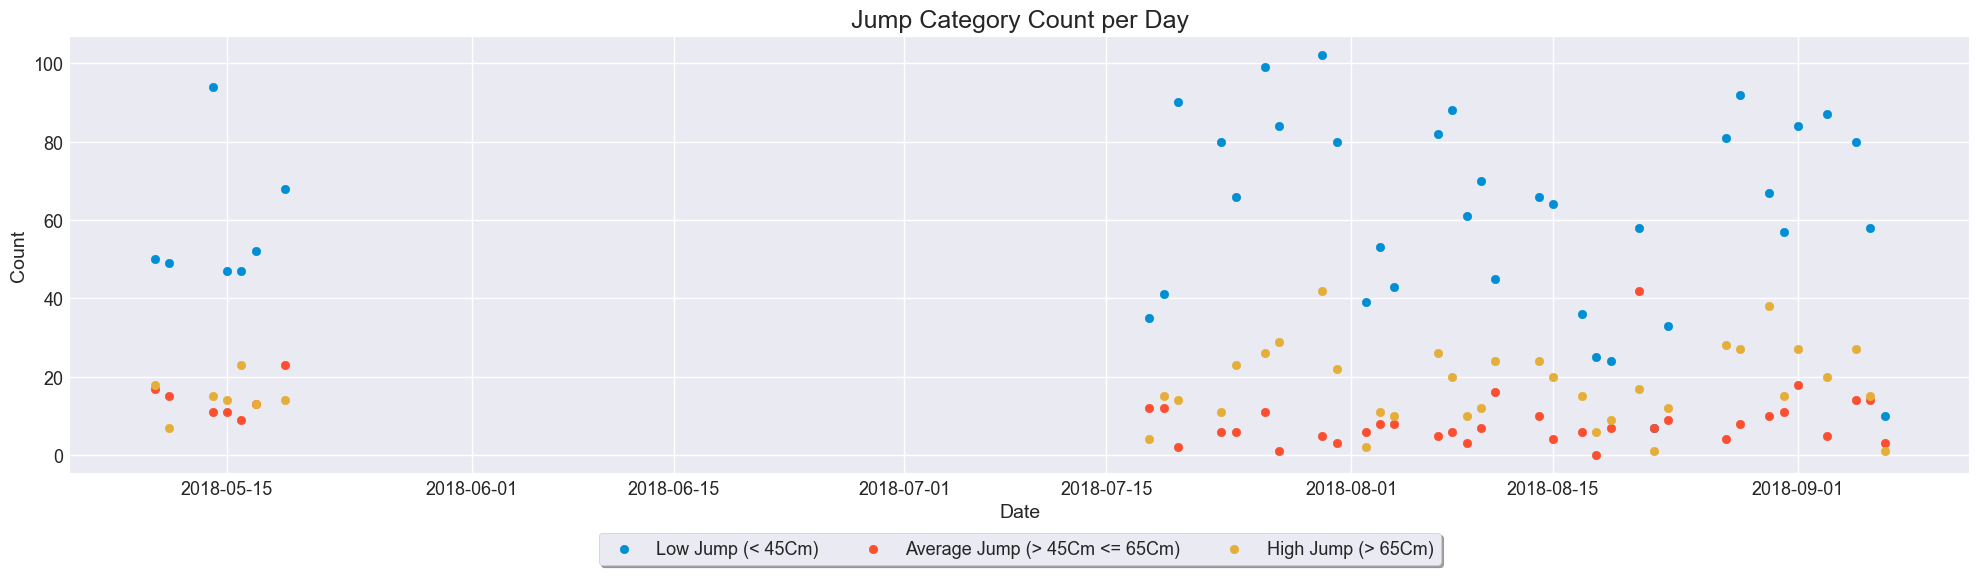

In [144]:
plt.figure(figsize=(20, 6), tight_layout=True)
# jumps_daily.JumpCount.plot(kind='line')
plt.scatter(jumps_daily['Date'], jumps_daily['LowJumpCount'], label='Low Jump (< 45Cm)')
plt.scatter(jumps_daily['Date'], jumps_daily['AverageJumpCount'], label='Average Jump (> 45Cm <= 65Cm)')
plt.scatter(jumps_daily['Date'], jumps_daily['HighJumpCount'], label='High Jump (> 65Cm)')
# jumps_daily.LowJumpCount.plot(kind='line', label='Low Jump (< 50Cm)')
# jumps_daily.AverageJumpCount.plot(kind='line', label='Low Jump (< 50Cm)')
# jumps_daily.HighJumpCount.plot(kind='line', label='Low Jump (< 50Cm)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True, ncol=3)
plt.xlabel('Date'); plt.ylabel('Count')
plt.title('Jump Category Count per Day')
plt.show()

2. Player Training Dataset (Information of volleyball-specific sessions)

In [11]:
# training_data = pd.read_excel('./data/PlayerTrainingData.xlsx')
# training_data.to_csv("./data/PlayerTrainingData.csv", index = None, header=True)

In [20]:
training_data = pd.read_excel('./data/PlayerTrainingData.xlsx')
training_data['Duration'] = pd.to_timedelta(training_data['Duration'])
print(f"Shape of Players Training dataset : {training_data.shape}")
print(training_data.dtypes)
training_data.head(5)

Shape of Players Training dataset : (106, 4)
TrainingID              int64
PlayerID                int64
RPE                   float64
Duration      timedelta64[ns]
dtype: object


,TrainingID,PlayerID,RPE,Duration
0,34,4,3.0,0 days 01:14:33.980000
1,35,4,5.0,0 days 03:00:00
2,36,4,6.0,0 days 02:25:00
3,37,4,4.0,0 days 01:07:48.390000
4,38,4,7.0,0 days 01:38:54.370000


In [21]:
training_data['Dur_m'] = (training_data['Duration'].dt.total_seconds()//60).round()
training_data['Dur_s'] = (training_data['Dur_m']*60)
training_data.head(5)

,TrainingID,PlayerID,RPE,Duration,Dur_m,Dur_s
0,34,4,3.0,0 days 01:14:33.980000,74.0,4440.0
1,35,4,5.0,0 days 03:00:00,180.0,10800.0
2,36,4,6.0,0 days 02:25:00,145.0,8700.0
3,37,4,4.0,0 days 01:07:48.390000,67.0,4020.0
4,38,4,7.0,0 days 01:38:54.370000,98.0,5880.0


In [22]:
training_data.isnull().sum()

TrainingID     0
PlayerID       0
RPE           14
Duration       0
Dur_m          0
Dur_s          0
dtype: int64

In [23]:
training_data = training_data.drop(columns=['PlayerID', 'Duration', 'Dur_m', 'Dur_s'])
training_data.isnull().sum()

TrainingID     0
RPE           14
dtype: int64

In [25]:
# training = training_data.dropna(subset=['RPE']).drop(columns=['PlayerID', 'Duration', 'Dur_m', 'Dur_s'])
# print(training.isnull().sum())
# training.head()

3. Player Exercise Training Dataset \
    (Information about the exercises in volleyball-specific sessions)

In [27]:
exercise_data = pd.read_csv('./data/ExerciseTrainingData.csv', sep=';')
exercise_data['Date'] = pd.to_datetime(exercise_data['Date'], format='%d-%m-%Y')
exercise_data['Duration'] = pd.to_timedelta(exercise_data['Duration'])
print(f"Shape of Players Exercise Training dataset : {exercise_data.shape}")
exercise_data.head()

Shape of Players Exercise Training dataset : (615, 13)


,Date,PlayerID,DateTime,DateEndTime,DateStartTime,Exercise #,ExerciseID,TrainingID,TrainingSubtype,TrainingType,Duration,Duration_s,Duration_m
0,2018-05-11,4,"00:00,0","32:16,3","28:15,8",Exercise 3,11.0,34.0,Complex technique,Technique,0 days 00:04:00.440000,240.0,4.0
1,2018-05-11,4,"00:00,0","54:59,8","32:16,9",Exercise 4,40.0,34.0,Team pass,Complex 1,0 days 00:22:42.890000,1362.0,22.0
2,2018-05-11,4,"00:00,0","20:39,1","05:55,4",Exercise 1,82.0,34.0,Warming up & Cooling down,Physical,0 days 00:14:43.670000,883.0,14.0
3,2018-05-11,4,"00:00,0","28:15,2","20:39,6",Exercise 2,2.0,34.0,Complex technique,Technique,0 days 00:07:35.590000,455.0,7.0
4,2018-05-11,4,"00:00,0","10:44,7","30:44,7",Exercise 1,82.0,35.0,Warming up & Cooling down,Physical,0 days 00:40:00,2400.0,40.0


In [28]:
exercise_data.dtypes

Date                datetime64[ns]
PlayerID                     int64
DateTime                    object
DateEndTime                 object
DateStartTime               object
Exercise #                  object
ExerciseID                 float64
TrainingID                 float64
TrainingSubtype             object
TrainingType                object
Duration           timedelta64[ns]
Duration_s                 float64
Duration_m                 float64
dtype: object

In [29]:
# for column in ['DateTime', 'DateEndTime', 'DateStartTime']:
#     exercise_data[column] = exercise_data[column].str.replace(',', '.')
#     exercise_data[column] = pd.to_datetime(exercise_data[column], format='%M:%S.%f')
# exercise_data.head()
exercise = exercise_data.drop(columns=['DateTime', 'DateEndTime', 'DateStartTime', 'Duration', 'PlayerID'])
exercise.head()

,Date,Exercise #,ExerciseID,TrainingID,TrainingSubtype,TrainingType,Duration_s,Duration_m
0,2018-05-11,Exercise 3,11.0,34.0,Complex technique,Technique,240.0,4.0
1,2018-05-11,Exercise 4,40.0,34.0,Team pass,Complex 1,1362.0,22.0
2,2018-05-11,Exercise 1,82.0,34.0,Warming up & Cooling down,Physical,883.0,14.0
3,2018-05-11,Exercise 2,2.0,34.0,Complex technique,Technique,455.0,7.0
4,2018-05-11,Exercise 1,82.0,35.0,Warming up & Cooling down,Physical,2400.0,40.0


In [30]:
exercise.isnull().sum()

Date                0
Exercise #         20
ExerciseID         20
TrainingID         20
TrainingSubtype    20
TrainingType       20
Duration_s         21
Duration_m         21
dtype: int64

In [31]:
exercise.dropna(inplace=True)

In [32]:
df = pd.merge(exercise, training_data, on=['TrainingID'], how='outer')
df.head()

,Date,Exercise #,ExerciseID,TrainingID,TrainingSubtype,TrainingType,Duration_s,Duration_m,RPE
0,2018-05-11,Exercise 3,11.0,34.0,Complex technique,Technique,240.0,4.0,3.0
1,2018-05-11,Exercise 4,40.0,34.0,Team pass,Complex 1,1362.0,22.0,3.0
2,2018-05-11,Exercise 1,82.0,34.0,Warming up & Cooling down,Physical,883.0,14.0,3.0
3,2018-05-11,Exercise 2,2.0,34.0,Complex technique,Technique,455.0,7.0,3.0
4,2018-05-11,Exercise 5,79.0,34.0,Team pass,Complex 1,997.0,16.0,3.0


In [33]:
# df.dropna(subset=['Exercise #', 'RPE'], inplace=True)
# df.drop(columns='Duration_m', inplace=True)
df['RPE'].interpolate(method='linear', inplace=True)
df.isnull().sum()

Date               9
Exercise #         9
ExerciseID         9
TrainingID         0
TrainingSubtype    9
TrainingType       9
Duration_s         9
Duration_m         9
RPE                0
dtype: int64

In [34]:
df.dropna(inplace=True)
print(f'Shape of df is {df.shape}')
df.head()

Shape of df is (596, 9)


,Date,Exercise #,ExerciseID,TrainingID,TrainingSubtype,TrainingType,Duration_s,Duration_m,RPE
0,2018-05-11,Exercise 3,11.0,34.0,Complex technique,Technique,240.0,4.0,3.0
1,2018-05-11,Exercise 4,40.0,34.0,Team pass,Complex 1,1362.0,22.0,3.0
2,2018-05-11,Exercise 1,82.0,34.0,Warming up & Cooling down,Physical,883.0,14.0,3.0
3,2018-05-11,Exercise 2,2.0,34.0,Complex technique,Technique,455.0,7.0,3.0
4,2018-05-11,Exercise 5,79.0,34.0,Team pass,Complex 1,997.0,16.0,3.0


In [35]:
df['Session_Load'] = ((df.Duration_s/60) * df.RPE).round()
# df['Dur'] = (df.Duration_s//60).round()
df.head()

,Date,Exercise #,ExerciseID,TrainingID,TrainingSubtype,TrainingType,Duration_s,Duration_m,RPE,Session_Load
0,2018-05-11,Exercise 3,11.0,34.0,Complex technique,Technique,240.0,4.0,3.0,12.0
1,2018-05-11,Exercise 4,40.0,34.0,Team pass,Complex 1,1362.0,22.0,3.0,68.0
2,2018-05-11,Exercise 1,82.0,34.0,Warming up & Cooling down,Physical,883.0,14.0,3.0,44.0
3,2018-05-11,Exercise 2,2.0,34.0,Complex technique,Technique,455.0,7.0,3.0,23.0
4,2018-05-11,Exercise 5,79.0,34.0,Team pass,Complex 1,997.0,16.0,3.0,50.0


In [36]:
# df[df.TrainingSubtype == 'Complex technique']
# df.RPE = df.RPE.interpolate()
# df.loc[133]
# df[df.RPE.isnull()]
# df_grouped = df.groupby('Date').agg({'Exercise #': list, 
#                                      'ExerciseID': list,
#                                      'Duration_s': 'sum',
#                                      'RPE': 'mean'}).reset_index()
df.TrainingSubtype.unique()

array(['Complex technique', 'Team pass', 'Warming up & Cooling down',
       'Technique team individueel', 'Friendly', 'pass-set-attack',
       'Serve', '6vs6', 'six-six', 'Strength', 'Set-Up', 'Pass', '5vs5',
       'blok-defense', 'GEL', 'Defense', 'Core', 'Specific power',
       'Setting', 'Attack', 'set-attack', 'Test', 'Match',
       'block-defense-attack', 'pass-set-attack-cover-rally attack',
       'Block', 'Agility', 'WK'], dtype=object)

In [37]:
df_encoded = pd.get_dummies(df, columns=['TrainingSubtype', 'TrainingType'])
# df_encoded = df.copy()

grouped_df = df_encoded.groupby('Date').agg({
    'Duration_s': 'sum',
    'Duration_m': 'sum',
    # 'Dur' : 'sum',
    # 'RPE': 'mean',
    'Session_Load': 'sum',
    
    **{col: 'sum' for col in df_encoded.columns if 'TrainingSubtype_' in col or 'TrainingType_' in col}
}).reset_index()

grouped_df['Duration_hrs'] = grouped_df.Duration_m//60
grouped_df['Session_Load'] = grouped_df.Session_Load//grouped_df.Duration_hrs
grouped_df.drop(columns=['Duration_s', 'Duration_m'], inplace=True)
print(f'Shape of df is : {grouped_df.shape}')
grouped_df.head(5)

Shape of df is : (65, 38)


,Date,Session_Load,TrainingSubtype_5vs5,TrainingSubtype_6vs6,TrainingSubtype_Agility,TrainingSubtype_Attack,TrainingSubtype_Block,TrainingSubtype_Complex technique,TrainingSubtype_Core,TrainingSubtype_Defense,TrainingSubtype_Friendly,TrainingSubtype_GEL,TrainingSubtype_Match,TrainingSubtype_Pass,TrainingSubtype_Serve,TrainingSubtype_Set-Up,TrainingSubtype_Setting,TrainingSubtype_Specific power,TrainingSubtype_Strength,TrainingSubtype_Team pass,TrainingSubtype_Technique team individueel,TrainingSubtype_Test,TrainingSubtype_WK,TrainingSubtype_Warming up & Cooling down,TrainingSubtype_block-defense-attack,TrainingSubtype_blok-defense,TrainingSubtype_pass-set-attack,TrainingSubtype_pass-set-attack-cover-rally attack,TrainingSubtype_set-attack,TrainingSubtype_six-six,TrainingType_Competition,TrainingType_Complex 1,TrainingType_Complex 2,TrainingType_Complex total,TrainingType_Match,TrainingType_Physical,TrainingType_Technique,Duration_hrs
0,2018-05-11,279.0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,2,1,0,0,2,0,0,0,0,0,0,1,2,0,0,0,2,3,4.0
1,2018-05-12,376.0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,2,0,0,0,3,0,0,1,0,0,0,1,3,0,0,0,3,2,3.0
2,2018-05-14,418.0,0,1,0,0,0,1,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,3,0,0,1,0,0,1,0,1,1,1,0,4,4,3.0
3,2018-05-15,534.0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,3,1,0,0,3,0,0,0,0,0,0,1,3,0,0,0,3,3,3.0
4,2018-05-16,360.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,3.0


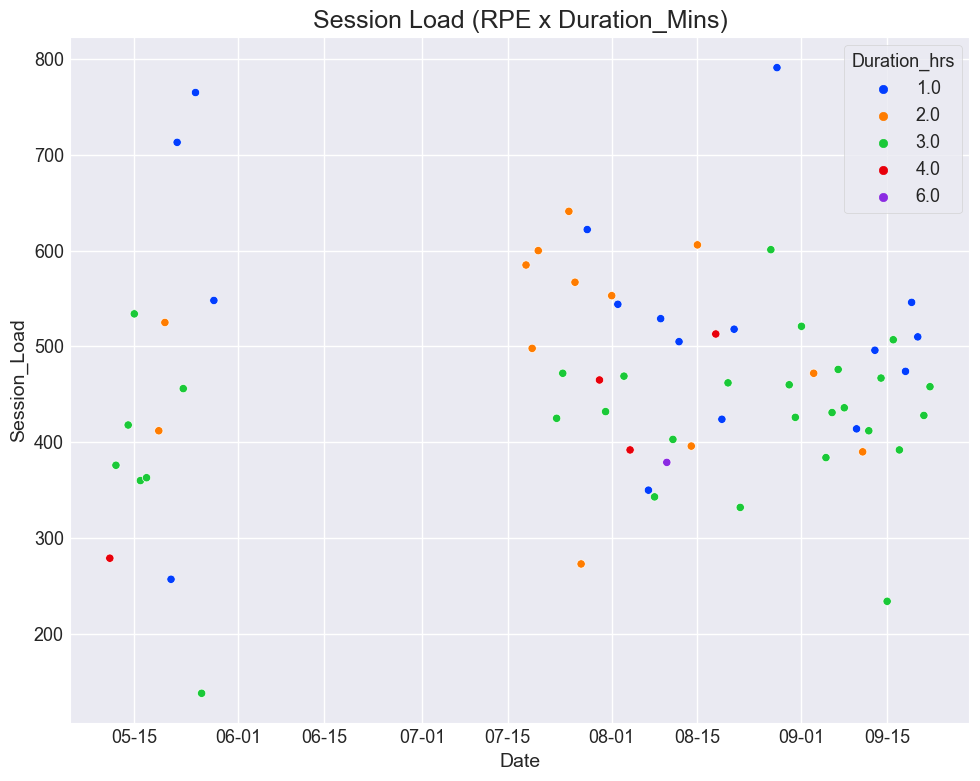

In [95]:
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)
sns.scatterplot(x='Date',
                y='Session_Load',
                data=grouped_df,
                hue='Duration_hrs',
                ax=ax, palette='bright')
# df_highlight = grouped_df[grouped_df['Difficultparticipating'] > ]
# plt.scatter(df_highlight['Date'], df_highlight['Difficultparticipating'], facecolors='none', edgecolors='r', s=200)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.title('Session Load (RPE x Duration_Mins)')
plt.show()

4. Player Strength Training Dataset (Information of strength training) \
(reps = repetitions, prct = percentage of personal maximum weight)

In [39]:
strength_data = pd.read_csv('./data/StrengthTraining.csv', sep=';')
# Replacing Dutch decimals with std decimals
strength_data['Prct'] = strength_data['Prct'].str.replace(',', '.').astype(float)
strength_data['Weight'] = strength_data['Weight'].str.replace(',', '.').astype(float)
strength_data['Date'] = pd.to_datetime(strength_data['Date'], format='%d-%m-%Y')
print(f"Shape of Players Strength Training dataset : {strength_data.shape}")
strength_data.head(5)

Shape of Players Strength Training dataset : (255, 7)


,PlayerID,Date,Focus,Exercise,Reps,Prct,Weight
0,4,2018-07-23,Maximaalkracht,Fullbody,4.0,0.90,50.0
1,4,2018-07-23,Maximaalkracht,Upper,12.0,0.85,19.0
2,4,2018-07-23,Maximaalkracht,Upper,12.0,0.85,18.6
3,4,2018-07-23,Maximaalkracht,Lower,3.0,0.93,105.0
4,4,2018-07-23,Maximaalkracht,Lower,4.0,0.90,100.0


In [40]:
strength_data.dropna(inplace=True)
strength_data.drop(columns=['PlayerID'], inplace=True)

In [41]:
strength_data.isnull().sum()

Date        0
Focus       0
Exercise    0
Reps        0
Prct        0
Weight      0
dtype: int64

5. Player Wellness Dataset 
    1) 	Answers wellness questions on a 10-point Likert scale ranging from 1 (very bad) to 10 (excellent)  
    2) 	Answers to OSTRC questions

In [42]:
wellness_data = pd.read_csv('./data/Wellness.csv', sep=';')
wellness_data['Date'] = pd.to_datetime(wellness_data['Date'], format='%d-%m-%Y')
print(f"Shape of Players Wellness dataset : {wellness_data.shape}")
wellness_data.head()

Shape of Players Wellness dataset : (85, 14)


,PlayerID,Date,Wellness,Mood,Recovered,Muscle Soreness,Sick/healthy,Injury,Sleep quality,Hours of sleep,Difficultparticipating,Reducedtraining,Affectedperformance,Symptomscomplaints
0,4,2018-05-10,47,7,7,7,10,10,6,8.0,0,0,0,0
1,4,2018-05-11,46,7,6,6,10,10,7,9.0,0,0,0,0
2,4,2018-05-12,46,7,6,6,10,10,7,9.0,1,0,1,1
3,4,2018-05-13,48,7,7,7,10,10,7,8.0,0,0,0,0
4,4,2018-05-14,42,6,5,5,10,10,6,8.0,1,1,1,1


In [43]:
wellness_data['Hours of sleep'] = wellness_data['Hours of sleep'].fillna(8)
wellness_data.drop(columns=['PlayerID'], inplace=True)
wellness_data.isnull().sum()

Date                      0
Wellness                  0
Mood                      0
Recovered                 0
Muscle Soreness           0
Sick/healthy              0
Injury                    0
Sleep quality             0
Hours of sleep            0
Difficultparticipating    0
Reducedtraining           0
Affectedperformance       0
Symptomscomplaints        0
dtype: int64

In [44]:
wellness_data['Injury'].value_counts()

Injury
10    34
8     25
7     12
9      8
6      5
5      1
Name: count, dtype: int64

In [145]:
def convert_osrtc_to_severity_3(score):
    return score * 100 // 3
def convert_osrtc_to_severity_4(score):
    return score * 100 // 4

In [46]:
wellness_data['Sev_DP'] = wellness_data['Difficultparticipating'].apply(convert_osrtc_to_severity_3)
wellness_data['Sev_RT'] = wellness_data['Reducedtraining'].apply(convert_osrtc_to_severity_4)
wellness_data['Sev_AP'] = wellness_data['Affectedperformance'].apply(convert_osrtc_to_severity_4)
wellness_data['Sev_SC'] = wellness_data['Symptomscomplaints'].apply(convert_osrtc_to_severity_3)
wellness_data.head()

,Date,Wellness,Mood,Recovered,Muscle Soreness,Sick/healthy,Injury,Sleep quality,Hours of sleep,Difficultparticipating,Reducedtraining,Affectedperformance,Symptomscomplaints,Sev_DP,Sev_RT,Sev_AP,Sev_SC
0,2018-05-10,47,7,7,7,10,10,6,8.0,0,0,0,0,0,0,0,0
1,2018-05-11,46,7,6,6,10,10,7,9.0,0,0,0,0,0,0,0,0
2,2018-05-12,46,7,6,6,10,10,7,9.0,1,0,1,1,33,0,25,33
3,2018-05-13,48,7,7,7,10,10,7,8.0,0,0,0,0,0,0,0,0
4,2018-05-14,42,6,5,5,10,10,6,8.0,1,1,1,1,33,25,25,33


In [47]:
# wellness_data.set_index('Date', inplace=True)
# wellness_data.head()

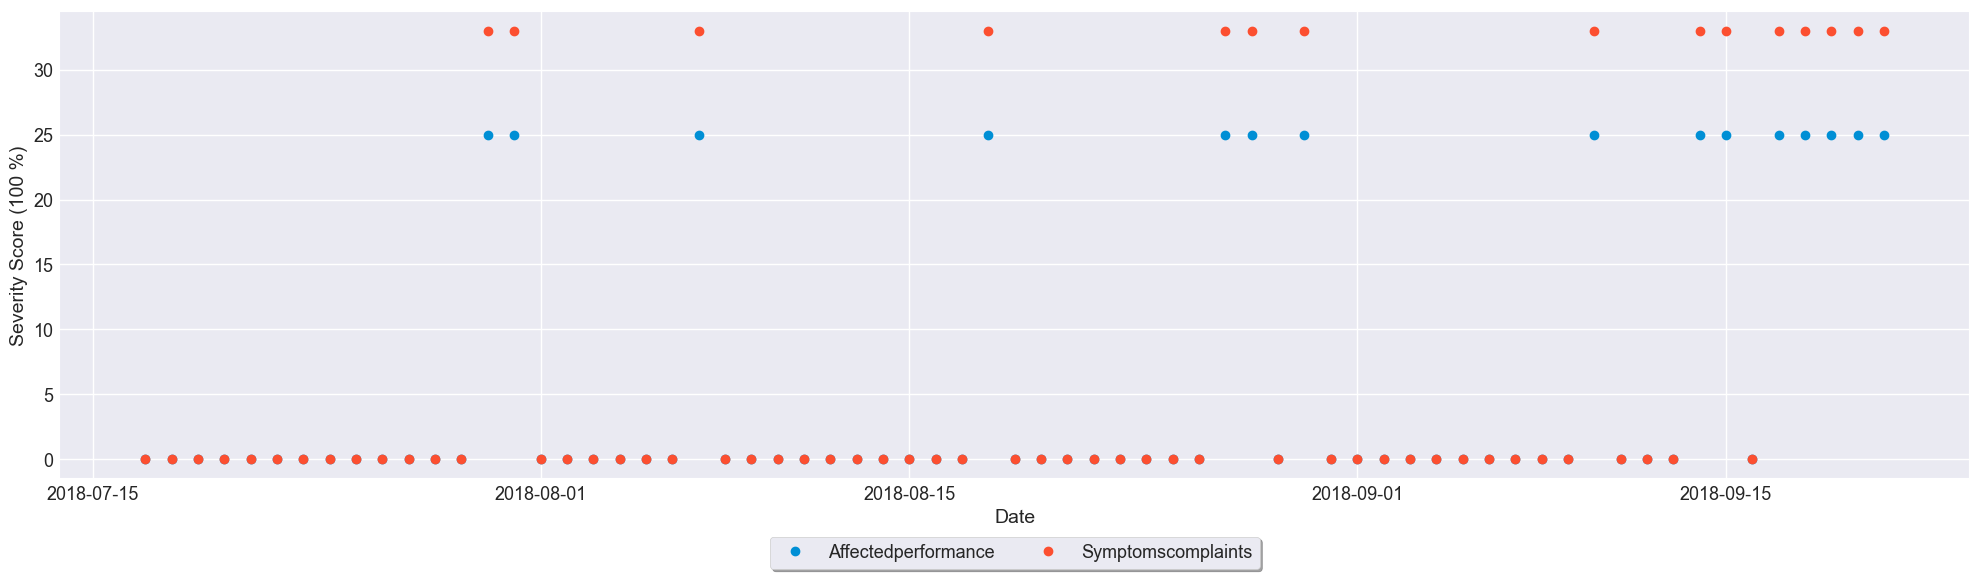

In [48]:
wellness_data_cp = wellness_data.copy()
wellness_data_cp.set_index('Date', inplace=True)
# wellness_data_cp.head()

start_date = '2018-07-15'
end_date = '2018-11-30'

df_week = wellness_data_cp.loc[start_date:end_date]

plt.figure(figsize=(20, 6), tight_layout=True)
# plt.plot(df_week.index, df_week.Sev_DP, 'o', label='Difficultparticipating')
# plt.plot(df_week.index, df_week.Sev_RT, 'o', label='Reducedtraining')
plt.plot(df_week.index, df_week.Sev_AP, 'o', label='Affectedperformance')
plt.plot(df_week.index, df_week.Sev_SC, 'o', label='Symptomscomplaints')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)
plt.xlabel('Date'); plt.ylabel('Severity Score (100 %)')
plt.show()

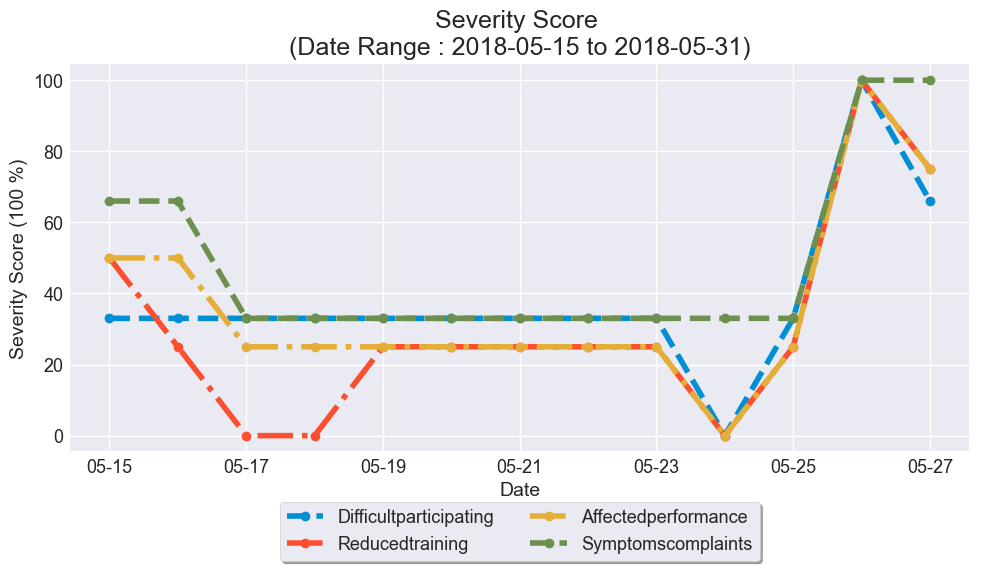

In [49]:
start_date = '2018-05-15'
end_date = '2018-5-31'

df_week = wellness_data_cp.loc[start_date:end_date]

fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
ax.plot(df_week.index, df_week.Sev_DP, 'o--', label='Difficultparticipating')
ax.plot(df_week.index, df_week.Sev_RT, 'o-.', label='Reducedtraining')
ax.plot(df_week.index, df_week.Sev_AP, 'o-.', label='Affectedperformance')
ax.plot(df_week.index, df_week.Sev_SC, '--o', label='Symptomscomplaints')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)
plt.xlabel('Date'); plt.ylabel('Severity Score (100 %)')
plt.title(f'Severity Score \n (Date Range : 2018-05-15 to 2018-05-31) ')
plt.show()

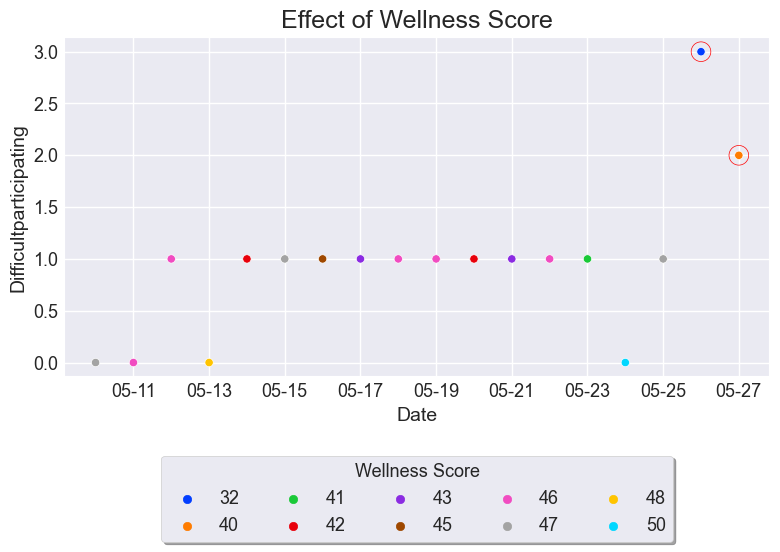

In [146]:
df_trail = wellness_data_cp.loc['2018-05-10':'2018-5-27']

fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)
sns.scatterplot(x='Date',
                y='Difficultparticipating',
                data=df_trail,
                hue='Wellness',
                ax=ax, palette='bright')

df_highlight = df_trail[df_trail['Wellness'] <= 40]
plt.scatter(df_highlight.index, df_highlight['Difficultparticipating'], facecolors='none', edgecolors='r', s=200)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.title('Effect of Wellness Score')

legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=5)
legend.set_title("Wellness Score")
plt.show()


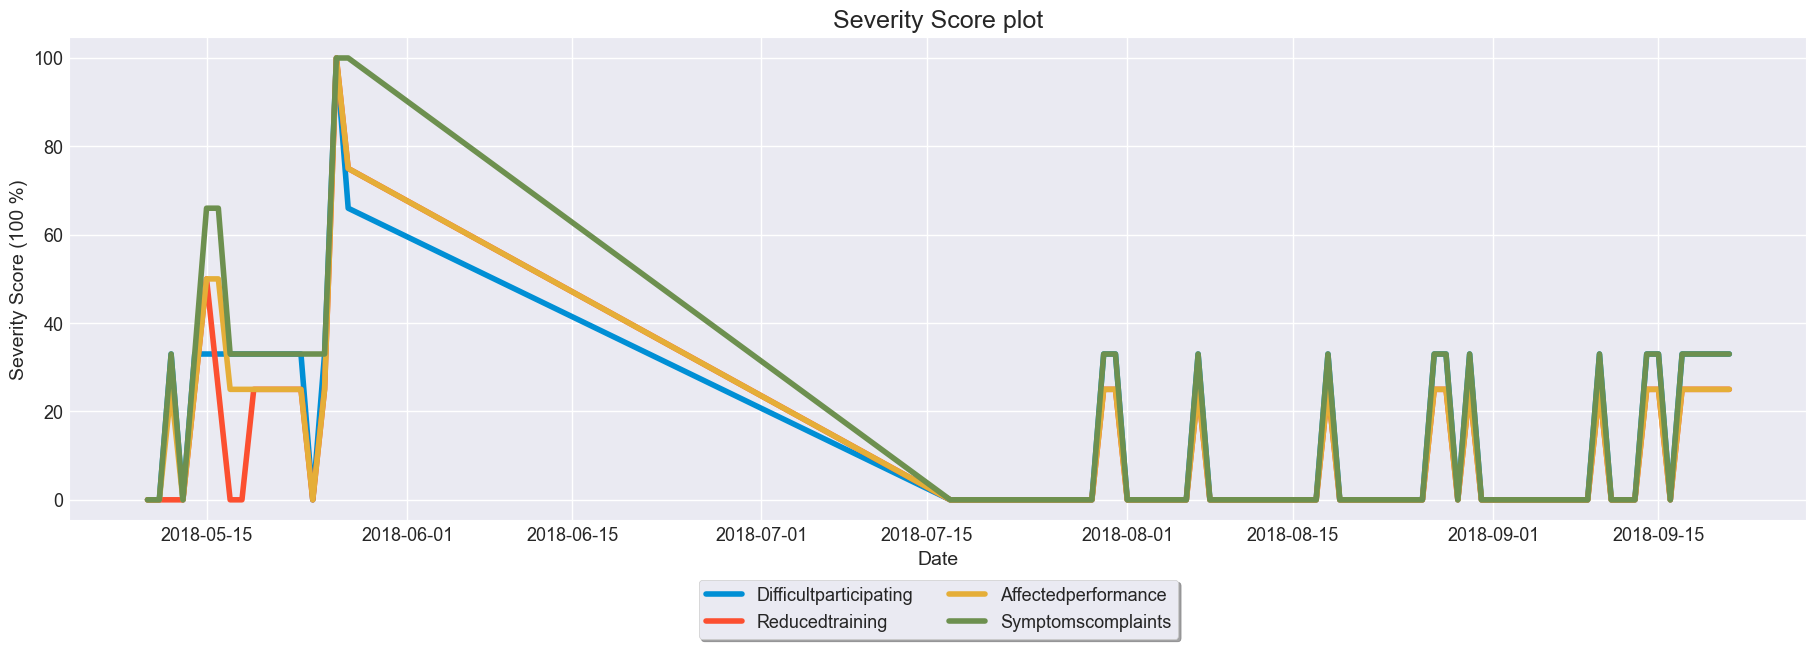

In [220]:
plt.figure(figsize=(20, 6))

plt.plot(wellness_data.Date, wellness_data.Sev_DP, label='Difficultparticipating')
plt.plot(wellness_data.Date, wellness_data.Sev_RT, label='Reducedtraining')
plt.plot(wellness_data.Date, wellness_data.Sev_AP, label='Affectedperformance')
plt.plot(wellness_data.Date, wellness_data.Sev_SC, label='Symptomscomplaints')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)
plt.xlabel('Date'); plt.ylabel('Severity Score (100 %)')
plt.title('Severity Score plot')
plt.show()

In [52]:
new_df = pd.merge(grouped_df, wellness_data, on=['Date'], how='outer')
new_df.dropna(inplace=True)
print(f'Shape of the dataset is {new_df.shape}')
new_df.head()

Shape of the dataset is (63, 54)


,Date,Session_Load,TrainingSubtype_5vs5,TrainingSubtype_6vs6,TrainingSubtype_Agility,TrainingSubtype_Attack,TrainingSubtype_Block,TrainingSubtype_Complex technique,TrainingSubtype_Core,TrainingSubtype_Defense,TrainingSubtype_Friendly,TrainingSubtype_GEL,TrainingSubtype_Match,TrainingSubtype_Pass,TrainingSubtype_Serve,TrainingSubtype_Set-Up,TrainingSubtype_Setting,TrainingSubtype_Specific power,TrainingSubtype_Strength,TrainingSubtype_Team pass,TrainingSubtype_Technique team individueel,TrainingSubtype_Test,TrainingSubtype_WK,TrainingSubtype_Warming up & Cooling down,TrainingSubtype_block-defense-attack,TrainingSubtype_blok-defense,TrainingSubtype_pass-set-attack,TrainingSubtype_pass-set-attack-cover-rally attack,TrainingSubtype_set-attack,TrainingSubtype_six-six,TrainingType_Competition,TrainingType_Complex 1,TrainingType_Complex 2,TrainingType_Complex total,TrainingType_Match,TrainingType_Physical,TrainingType_Technique,Duration_hrs,Wellness,Mood,Recovered,Muscle Soreness,Sick/healthy,Injury,Sleep quality,Hours of sleep,Difficultparticipating,Reducedtraining,Affectedperformance,Symptomscomplaints,Sev_DP,Sev_RT,Sev_AP,Sev_SC
0,2018-05-11,279.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,3.0,4.0,46.0,7.0,6.0,6.0,10.0,10.0,7.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-05-12,376.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,3.0,2.0,3.0,46.0,7.0,6.0,6.0,10.0,10.0,7.0,9.0,1.0,0.0,1.0,1.0,33.0,0.0,25.0,33.0
2,2018-05-14,418.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,4.0,4.0,3.0,42.0,6.0,5.0,5.0,10.0,10.0,6.0,8.0,1.0,1.0,1.0,1.0,33.0,25.0,25.0,33.0
3,2018-05-15,534.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,3.0,3.0,3.0,47.0,9.0,6.0,6.0,10.0,7.0,9.0,8.0,1.0,2.0,2.0,2.0,33.0,50.0,50.0,66.0
4,2018-05-16,360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,45.0,8.0,7.0,7.0,10.0,7.0,6.0,9.0,1.0,1.0,2.0,2.0,33.0,25.0,50.0,66.0


# Data Merging Process

In [278]:
from functools import reduce

data_frames = [jumps_daily, wellness_data, grouped_df]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), data_frames)
print(f'Shape of the dataset : {df_merged.shape}')
df_merged.head()

Shape of the dataset : (87, 63)


,Date,JumpCount,SumJumpHeight,AvgJumpHeight,MaxJumpHeight,MinJumpHeight,StdJumpHeight,LowJumpCount,AverageJumpCount,HighJumpCount,Wellness,Mood,Recovered,Muscle Soreness,Sick/healthy,Injury,Sleep quality,Hours of sleep,Difficultparticipating,Reducedtraining,Affectedperformance,Symptomscomplaints,Sev_DP,Sev_RT,Sev_AP,Sev_SC,Session_Load,TrainingSubtype_5vs5,TrainingSubtype_6vs6,TrainingSubtype_Agility,TrainingSubtype_Attack,TrainingSubtype_Block,TrainingSubtype_Complex technique,TrainingSubtype_Core,TrainingSubtype_Defense,TrainingSubtype_Friendly,TrainingSubtype_GEL,TrainingSubtype_Match,TrainingSubtype_Pass,TrainingSubtype_Serve,TrainingSubtype_Set-Up,TrainingSubtype_Setting,TrainingSubtype_Specific power,TrainingSubtype_Strength,TrainingSubtype_Team pass,TrainingSubtype_Technique team individueel,TrainingSubtype_Test,TrainingSubtype_WK,TrainingSubtype_Warming up & Cooling down,TrainingSubtype_block-defense-attack,TrainingSubtype_blok-defense,TrainingSubtype_pass-set-attack,TrainingSubtype_pass-set-attack-cover-rally attack,TrainingSubtype_set-attack,TrainingSubtype_six-six,TrainingType_Competition,TrainingType_Complex 1,TrainingType_Complex 2,TrainingType_Complex total,TrainingType_Match,TrainingType_Physical,TrainingType_Technique,Duration_hrs
0,2018-05-10,85.0,4631.0,54.482353,76.0,13.0,15.240619,50.0,17.0,18.0,47.0,7.0,7.0,7.0,10.0,10.0,6.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-11,71.0,4126.0,58.112676,77.0,13.0,12.036313,49.0,15.0,7.0,46.0,7.0,6.0,6.0,10.0,10.0,7.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,279.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,3.0,4.0
2,2018-05-14,120.0,6685.0,55.708333,76.0,15.0,10.099002,94.0,11.0,15.0,42.0,6.0,5.0,5.0,10.0,10.0,6.0,8.0,1.0,1.0,1.0,1.0,33.0,25.0,25.0,33.0,418.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,4.0,4.0,3.0
3,2018-05-15,72.0,3927.0,54.541667,73.0,20.0,12.805080,47.0,11.0,14.0,47.0,9.0,6.0,6.0,10.0,7.0,9.0,8.0,1.0,2.0,2.0,2.0,33.0,50.0,50.0,66.0,534.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,3.0,3.0,3.0
4,2018-05-16,79.0,4059.0,51.379747,72.0,18.0,14.967746,47.0,9.0,23.0,45.0,8.0,7.0,7.0,10.0,7.0,6.0,9.0,1.0,1.0,2.0,2.0,33.0,25.0,50.0,66.0,360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0


In [279]:
df_merged.interpolate(method='linear', inplace=True)
# df_merged['Session_Load'].fillna(method='bfill', inplace=True)  
# df_merged['Duration_hrs'].fillna(method='bfill', inplace=True)
df_merged.fillna(method='bfill', inplace=True)
df_merged.Duration_hrs = df_merged.Duration_hrs.round()
df_merged.head()

,Date,JumpCount,SumJumpHeight,AvgJumpHeight,MaxJumpHeight,MinJumpHeight,StdJumpHeight,LowJumpCount,AverageJumpCount,HighJumpCount,Wellness,Mood,Recovered,Muscle Soreness,Sick/healthy,Injury,Sleep quality,Hours of sleep,Difficultparticipating,Reducedtraining,Affectedperformance,Symptomscomplaints,Sev_DP,Sev_RT,Sev_AP,Sev_SC,Session_Load,TrainingSubtype_5vs5,TrainingSubtype_6vs6,TrainingSubtype_Agility,TrainingSubtype_Attack,TrainingSubtype_Block,TrainingSubtype_Complex technique,TrainingSubtype_Core,TrainingSubtype_Defense,TrainingSubtype_Friendly,TrainingSubtype_GEL,TrainingSubtype_Match,TrainingSubtype_Pass,TrainingSubtype_Serve,TrainingSubtype_Set-Up,TrainingSubtype_Setting,TrainingSubtype_Specific power,TrainingSubtype_Strength,TrainingSubtype_Team pass,TrainingSubtype_Technique team individueel,TrainingSubtype_Test,TrainingSubtype_WK,TrainingSubtype_Warming up & Cooling down,TrainingSubtype_block-defense-attack,TrainingSubtype_blok-defense,TrainingSubtype_pass-set-attack,TrainingSubtype_pass-set-attack-cover-rally attack,TrainingSubtype_set-attack,TrainingSubtype_six-six,TrainingType_Competition,TrainingType_Complex 1,TrainingType_Complex 2,TrainingType_Complex total,TrainingType_Match,TrainingType_Physical,TrainingType_Technique,Duration_hrs
0,2018-05-10,85.0,4631.0,54.482353,76.0,13.0,15.240619,50.0,17.0,18.0,47.0,7.0,7.0,7.0,10.0,10.0,6.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,279.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,3.0,4.0
1,2018-05-11,71.0,4126.0,58.112676,77.0,13.0,12.036313,49.0,15.0,7.0,46.0,7.0,6.0,6.0,10.0,10.0,7.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,279.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,3.0,4.0
2,2018-05-14,120.0,6685.0,55.708333,76.0,15.0,10.099002,94.0,11.0,15.0,42.0,6.0,5.0,5.0,10.0,10.0,6.0,8.0,1.0,1.0,1.0,1.0,33.0,25.0,25.0,33.0,418.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,4.0,4.0,3.0
3,2018-05-15,72.0,3927.0,54.541667,73.0,20.0,12.805080,47.0,11.0,14.0,47.0,9.0,6.0,6.0,10.0,7.0,9.0,8.0,1.0,2.0,2.0,2.0,33.0,50.0,50.0,66.0,534.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,3.0,3.0,3.0
4,2018-05-16,79.0,4059.0,51.379747,72.0,18.0,14.967746,47.0,9.0,23.0,45.0,8.0,7.0,7.0,10.0,7.0,6.0,9.0,1.0,1.0,2.0,2.0,33.0,25.0,50.0,66.0,360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0


In [56]:
# df_merged.dropna(subset=['Injury'], inplace=True)
# df_merged.dropna(inplace=True)
# df_merged.drop_duplicates(inplace=True)
# df_merged.shape

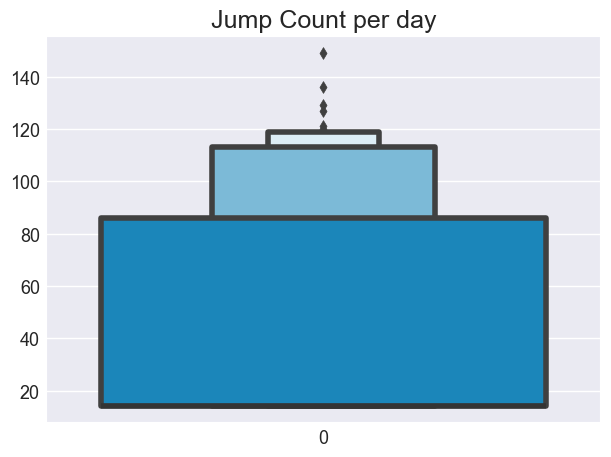

In [153]:
sns.boxenplot(df_merged['JumpCount'])
plt.title('Jump Count per day')
plt.show()

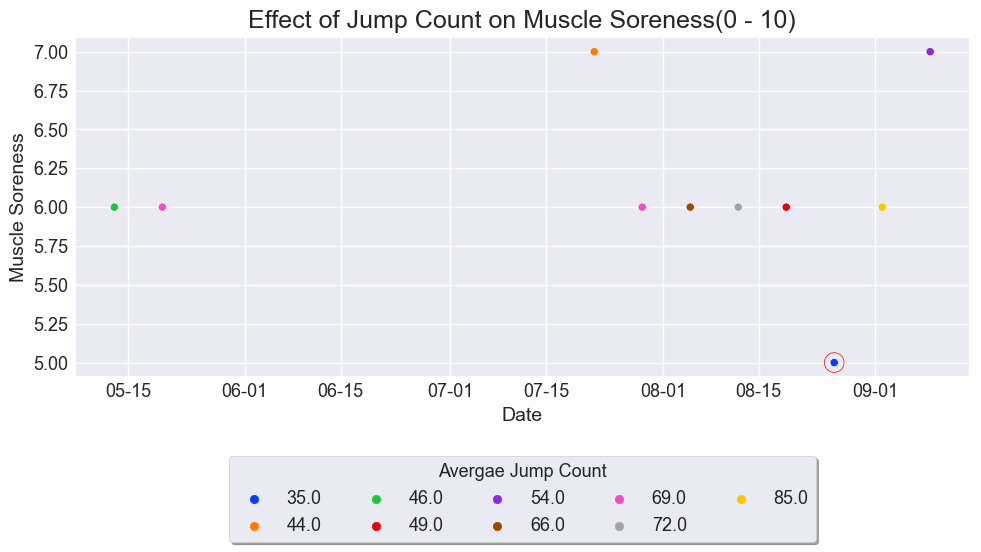

In [186]:
weekly_df_jump = df_merged.copy()
weekly_df_jump.set_index('Date', inplace=True)
weekly_df_jump = weekly_df_jump.resample('W').mean()
weekly_df_jump['Muscle Soreness'] = weekly_df_jump['Muscle Soreness'].round()
weekly_df_jump['JumpCount'] = weekly_df_jump['JumpCount'].round()
weekly_df_jump = weekly_df_jump[weekly_df_jump['JumpCount']>14]
fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)
sns.scatterplot(x='Date',
                y='Muscle Soreness',
                data=weekly_df_jump,
                hue='JumpCount',
                ax=ax, palette='bright')

df_highlights = weekly_df_jump[weekly_df_jump['JumpCount'] <=35]
plt.scatter(df_highlights.index, df_highlights['Muscle Soreness'], facecolors='none', edgecolors='r', s=200)
    
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.title('Effect of Jump Count on Muscle Soreness(0 - 10)')

legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=5)
legend.set_title("Avergae Jump Count")
plt.show()

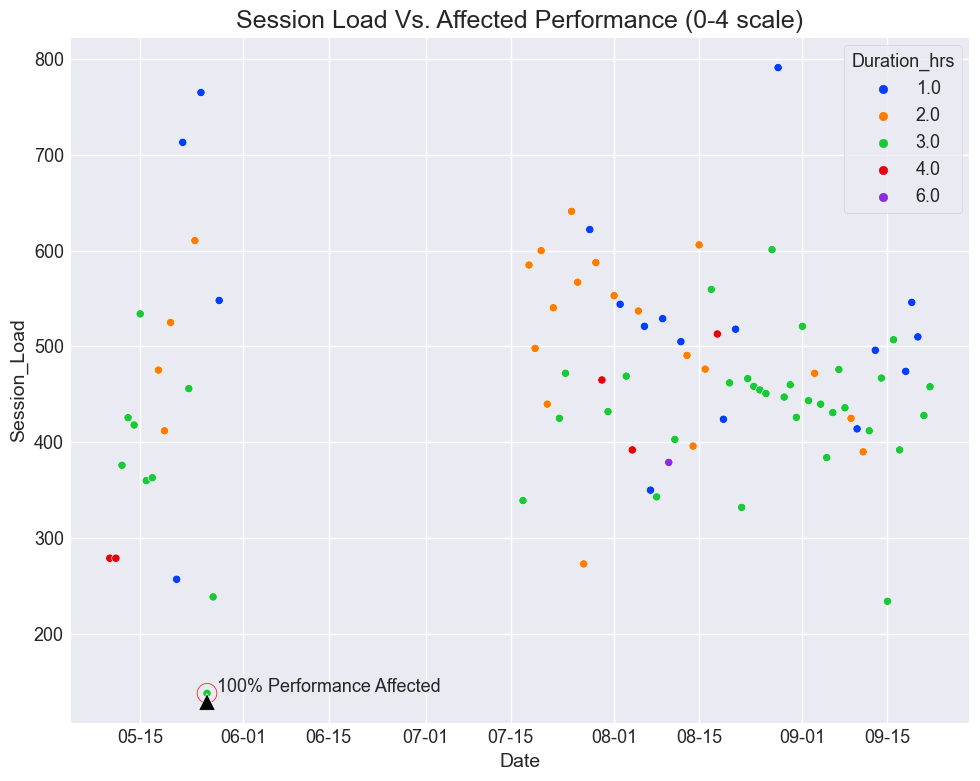

In [125]:
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)
sns.scatterplot(x='Date',
                y='Session_Load',
                data=df_merged,
                hue='Duration_hrs',
                ax=ax, palette='bright')
df_highlights = df_merged[df_merged['Affectedperformance'] > 3 ]
plt.scatter(df_highlights['Date'], df_highlights['Session_Load'], facecolors='none', edgecolors='r', s=200)

for i, row in df_highlights.iterrows():
    ax.annotate('  100% Performance Affected', 
                xy=(row['Date'], row['Session_Load']), 
                xytext=(row['Date'], row['Session_Load'] + 1), 
                arrowprops=dict(facecolor='black', shrink=0.1))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.title('Session Load Vs. Affected Performance (0-4 scale)')
plt.show()

In [57]:
# df_out = df_merged.copy()
# cols_to_drop = df_out.filter(regex='^Training').columns
# df_out.drop(columns=cols_to_drop, inplace=True)
# df_out.drop(columns=['Date', 'Difficultparticipating', 'Reducedtraining', 'Affectedperformance', 'Symptomscomplaints'], inplace=True)
# # print(df_out.shape)
# df_out.to_csv('./data/final_out.csv', index=False)

# Machine Learning Modeling - Regression Approach

In [336]:
df_numeric = df_merged.select_dtypes(include=[np.number])
# df_numeric.drop(columns=['Difficultparticipating', 'Reducedtraining', 'Affectedperformance', 'Symptomscomplaints'], inplace=True)
df_numeric.drop(columns=['Sev_DP', 'Sev_RT', 'Sev_AP', 'Sev_SC'], inplace=True)
print(f'Shape:{df_numeric.shape}')
df_numeric.head()

Shape:(87, 58)


,JumpCount,SumJumpHeight,AvgJumpHeight,MaxJumpHeight,MinJumpHeight,StdJumpHeight,LowJumpCount,AverageJumpCount,HighJumpCount,Wellness,Mood,Recovered,Muscle Soreness,Sick/healthy,Injury,Sleep quality,Hours of sleep,Difficultparticipating,Reducedtraining,Affectedperformance,Symptomscomplaints,Session_Load,TrainingSubtype_5vs5,TrainingSubtype_6vs6,TrainingSubtype_Agility,TrainingSubtype_Attack,TrainingSubtype_Block,TrainingSubtype_Complex technique,TrainingSubtype_Core,TrainingSubtype_Defense,TrainingSubtype_Friendly,TrainingSubtype_GEL,TrainingSubtype_Match,TrainingSubtype_Pass,TrainingSubtype_Serve,TrainingSubtype_Set-Up,TrainingSubtype_Setting,TrainingSubtype_Specific power,TrainingSubtype_Strength,TrainingSubtype_Team pass,TrainingSubtype_Technique team individueel,TrainingSubtype_Test,TrainingSubtype_WK,TrainingSubtype_Warming up & Cooling down,TrainingSubtype_block-defense-attack,TrainingSubtype_blok-defense,TrainingSubtype_pass-set-attack,TrainingSubtype_pass-set-attack-cover-rally attack,TrainingSubtype_set-attack,TrainingSubtype_six-six,TrainingType_Competition,TrainingType_Complex 1,TrainingType_Complex 2,TrainingType_Complex total,TrainingType_Match,TrainingType_Physical,TrainingType_Technique,Duration_hrs
0,85.0,4631.0,54.482353,76.0,13.0,15.240619,50.0,17.0,18.0,47.0,7.0,7.0,7.0,10.0,10.0,6.0,8.0,0.0,0.0,0.0,0.0,279.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,3.0,4.0
1,71.0,4126.0,58.112676,77.0,13.0,12.036313,49.0,15.0,7.0,46.0,7.0,6.0,6.0,10.0,10.0,7.0,9.0,0.0,0.0,0.0,0.0,279.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,3.0,4.0
2,120.0,6685.0,55.708333,76.0,15.0,10.099002,94.0,11.0,15.0,42.0,6.0,5.0,5.0,10.0,10.0,6.0,8.0,1.0,1.0,1.0,1.0,418.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,4.0,4.0,3.0
3,72.0,3927.0,54.541667,73.0,20.0,12.805080,47.0,11.0,14.0,47.0,9.0,6.0,6.0,10.0,7.0,9.0,8.0,1.0,2.0,2.0,2.0,534.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,3.0,3.0,3.0
4,79.0,4059.0,51.379747,72.0,18.0,14.967746,47.0,9.0,23.0,45.0,8.0,7.0,7.0,10.0,7.0,6.0,9.0,1.0,1.0,2.0,2.0,360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0


# Data Split

In [337]:
from sklearn.model_selection import train_test_split

X = df_numeric.drop(columns=['Injury'])
y = df_numeric['Injury']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 1) RandomForest Regressor

In [338]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

regr = RandomForestRegressor(random_state=1234)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
acc = regr.score(X_test, y_test)
print(f'accuarcy of RF : {acc:.3} \n')

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE for RF regressor: {rmse} \n")

accuarcy of RF : 0.663 

RMSE for RF regressor: 0.7737690343497331 



In [342]:
importances = regr.feature_importances_
indices = np.argsort(importances)[::-1]

print(f"Feature ranking:")
for f in range(10): print(f"\t{X.columns[indices[f]]}: {importances[indices[f]]}")

Feature ranking:
	Wellness: 0.3567462862094703
	Sick/healthy: 0.08826967481677951
	Reducedtraining: 0.07001089401132962
	Symptomscomplaints: 0.06664492165395554
	Session_Load: 0.058435618403921176
	LowJumpCount: 0.037259802632859294
	Mood: 0.023233685710693126
	TrainingType_Technique : 0.021343377764264697
	Sleep quality: 0.01985019043538521
	Difficultparticipating: 0.019388762275726217


# 2) GradientBoostingRegressor

In [289]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=50, learning_rate=0.3, random_state=123)
gbr.fit(X_train, y_train)
gbr_acc = gbr.score(X_test, y_test)
print(f'accuarcy of GBR : {gbr_acc:.3} \n')

y_pred_gbr = gbr.predict(X_test)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
print(f"RMSE for GBR: {rmse_gbr}")

accuarcy of GBR : 0.76 

RMSE for GBR: 0.6537560420059018


In [341]:
importances = gbr.feature_importances_
indices = np.argsort(importances)[::-1]
print(f"Feature ranking:")
for f in range(10): print(f"\t{X.columns[indices[f]]}: {importances[indices[f]]}")

Feature ranking:
	Wellness: 0.39237588670378987
	Mood: 0.1217623204437162
	Symptomscomplaints: 0.08285803028478311
	Sick/healthy: 0.07577858380875048
	LowJumpCount: 0.046474973949352794
	Sleep quality: 0.04013130842646505
	TrainingType_Technique : 0.03281959380560597
	Session_Load: 0.02719868981457957
	Reducedtraining: 0.025623880243284762
	TrainingType_Complex 2: 0.018543150375124


# 3) XGBRegressor

In [291]:
import xgboost as xgb

xbg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.6, max_depth=5, alpha=5, n_estimators=100)
xbg_reg.fit(X_train, y_train)
xbg_reg_acc = xbg_reg.score(X_test, y_test)
print(f'accuarcy of GBR : {xbg_reg_acc:.3} \n')

y_pred_xgb = xbg_reg.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"RMSE for XGBoost: {rmse_xgb}")

accuarcy of GBR : 0.512 

RMSE for XGBoost: 0.9316711730405098


In [340]:
importances = xbg_reg.feature_importances_
indices = np.argsort(importances)[::-1]
print(f"Feature ranking:")
for f in range(10): print(f"\t{X.columns[indices[f]]}: {importances[indices[f]]}")

Feature ranking:
	Symptomscomplaints: 0.21373876929283142
	TrainingSubtype_Serve: 0.17733865976333618
	Session_Load: 0.11358420550823212
	Sick/healthy: 0.1132960245013237
	TrainingSubtype_Set-Up: 0.07287487387657166
	TrainingSubtype_Technique team individueel: 0.0653168186545372
	TrainingType_Physical: 0.050903476774692535
	TrainingType_Technique : 0.04703217372298241
	TrainingSubtype_6vs6: 0.03529885411262512
	AvgJumpHeight: 0.023336030542850494


# Time Forecasting models

In [293]:
# metric to find the efficinecy of the time forecasting models
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Model 4: Autoregressive integrated moving average (ARIMA)

RMSE for ARIMA: 0.847
MAPE for ARIMA: 8.19%


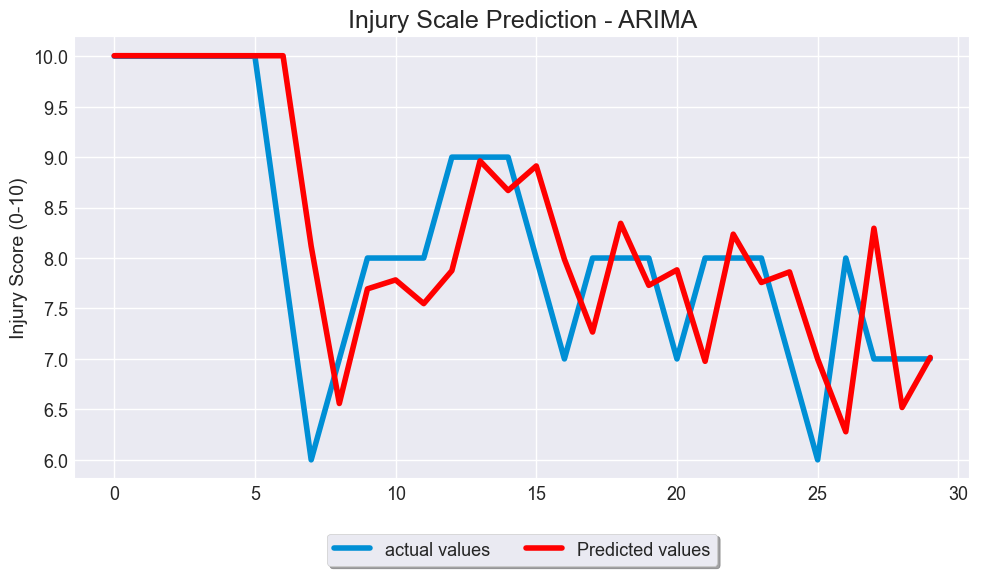

In [218]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

series = df_merged['Injury']

size = int(len(series) * 0.66)  
train, test = series[0:size], series[size:len(series)]

history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(3,2,1))  
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(yhat)
    obs = test.iloc[t]
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))

rmse = np.sqrt(mean_squared_error(test, predictions))
print('RMSE for ARIMA: %.3f' % rmse)

mape = mean_absolute_percentage_error(test, predictions)
print(f'MAPE for ARIMA: {mape:.2f}%')

plt.figure(figsize=(10, 6), tight_layout=True)
plt.plot(test.values, label='actual values')
plt.plot(predictions, color='red', label='Predicted values')
plt.title('Injury Scale Prediction - ARIMA')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)
plt.ylabel('Injury Score (0-10)')
plt.show()

# Model 5: Seasonal Autoregressive Integrated Moving Average Exogenous model (SARIMAX)

c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\optimizer.py:728: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=10.656560, expected=10.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=10.941918, expected=10.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=10.783447, expected=10.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=11.357141, expected=10.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=11.253882, expected=10.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=6.747896, expected=10.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=12.727763, expected=8.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=12.145485, expected=6.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=11.850798, expected=7.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=11.351142, expected=8.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=5.996323, expected=8.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=6.840446, expected=8.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.185205, expected=9.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.855691, expected=9.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.993510, expected=9.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=9.135741, expected=8.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=9.715565, expected=7.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=4.447350, expected=8.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.571891, expected=8.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=6.251447, expected=8.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=9.052302, expected=7.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.985856, expected=8.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.442939, expected=8.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.867121, expected=8.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.686683, expected=7.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=6.781563, expected=6.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=6.204687, expected=8.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=6.634519, expected=7.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=5.788136, expected=7.000000


c:\Users\rsury\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=6.665080, expected=7.000000
RMSE for SARIMAX: 2.267
MAPE of SARIMAX: 21.79%


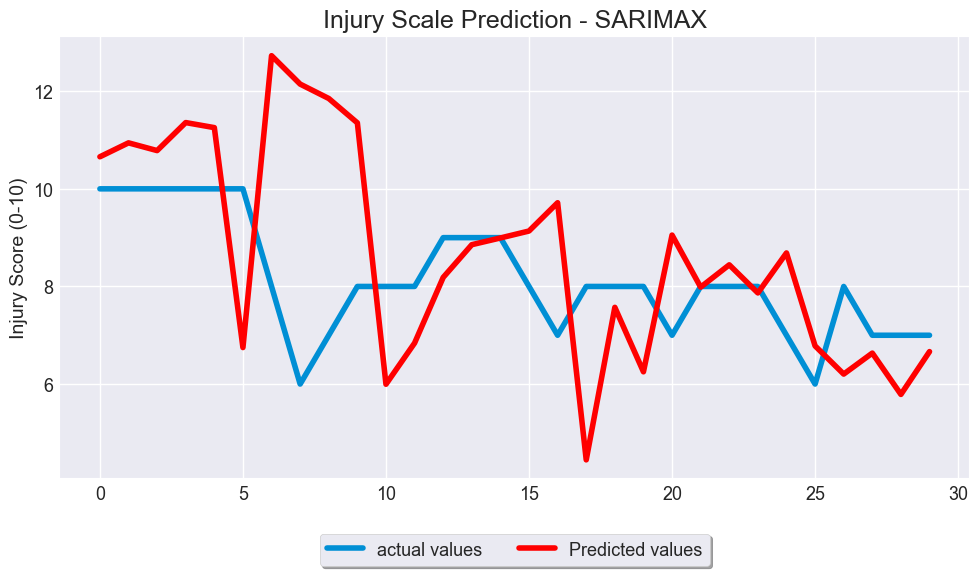

In [219]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

series = df_merged['Injury']
size = int(len(series) * 0.66)  
train, test = series[0:size], series[size:len(series)]

history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = SARIMAX(history, order=(3,2,1), seasonal_order=(3,2,1,12))
    # model_fit = model.fit(disp=0)
    model_fit = model.fit(maxiter=1000, method='nm')
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test.iloc[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

rmse = np.sqrt(mean_squared_error(test, predictions))
print('RMSE for SARIMAX: %.3f' % rmse)

mape_sarima = mean_absolute_percentage_error(test, predictions)
print(f'MAPE of SARIMAX: {mape_sarima:.2f}%')

plt.figure(figsize=(10, 6), tight_layout=True)
plt.plot(test.values, label='actual values')
plt.plot(predictions, color='red', label='Predicted values')
plt.title('Injury Scale Prediction - SARIMAX')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)
plt.ylabel('Injury Score (0-10)')
plt.show()


# ML Modeling - Classification Approach

In [344]:
# Consider !)-Scale Likert values less than 8 in Injury column as injury.
def injury_lbl(score):
    if score >=8 : return 0
    else: return 1

In [345]:
df_numeric = df_merged.copy()
df_numeric.Injury = df_numeric.Injury.apply(injury_lbl)
# df_numeric.head(1)

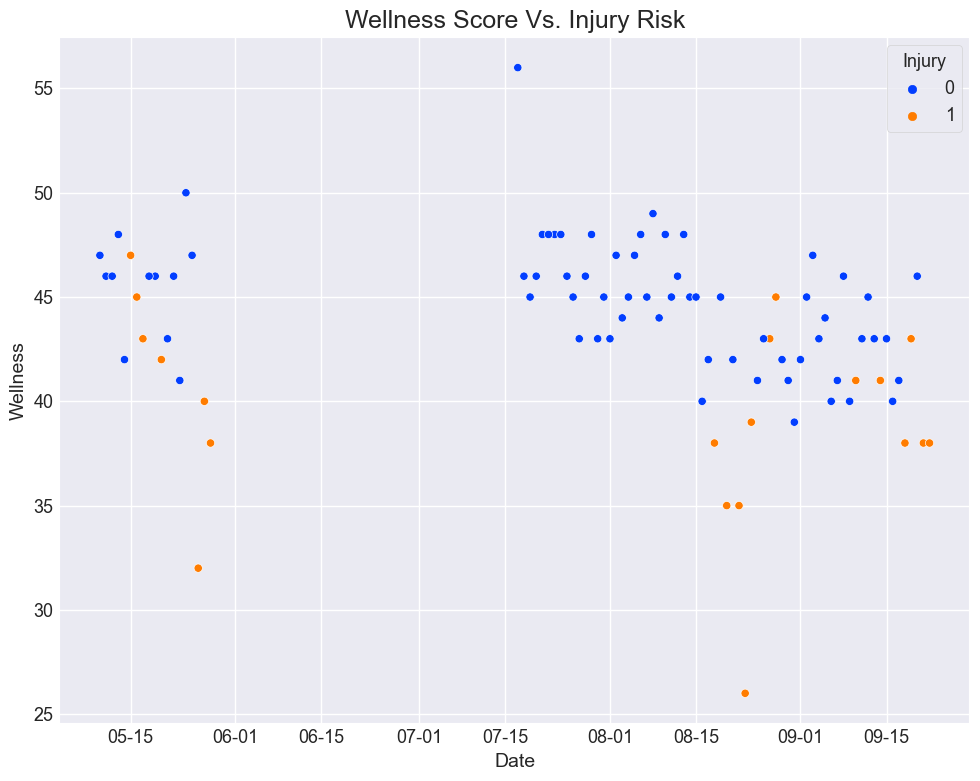

In [346]:
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)
sns.scatterplot(x='Date',
                y='Wellness',
                data=df_numeric,
                hue='Injury',
                ax=ax, palette='bright')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.title('Wellness Score Vs. Injury Risk')
plt.show()

# Train / Test Split

In [347]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

X = df_numeric.drop(columns=['Injury', 'Date'])
y = df_numeric['Injury']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model 1: GradientBoostingClassifier

              precision    recall  f1-score   support

           0       0.72      0.95      0.82        19
           1       0.50      0.12      0.20         8

    accuracy                           0.70        27
   macro avg       0.61      0.54      0.51        27
weighted avg       0.65      0.70      0.64        27

Accuracy of GradientBoosting Classifier: 70.37%


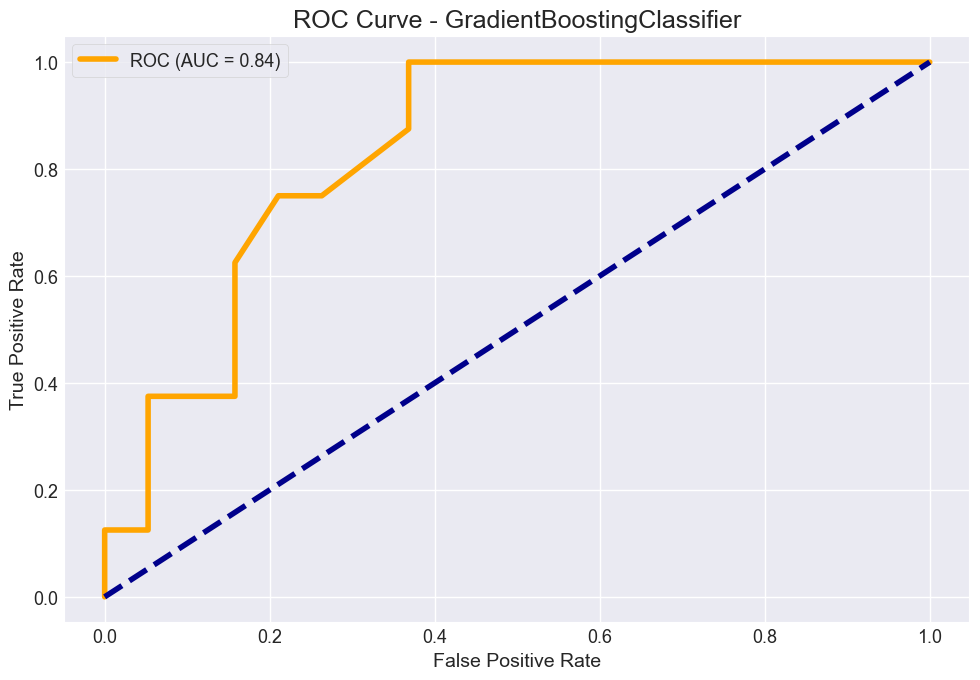

In [348]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Init model
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train & Pred
gb_clf.fit(X_train, y_train)

y_pred = gb_clf.predict(X_test)

print(classification_report(y_test, y_pred))

print(f"Accuracy of GradientBoosting Classifier: {accuracy_score(y_test, y_pred)*100:.2f}%")

# ROC-AUC Curve
Y_test_probability_true = gb_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, Y_test_probability_true)
auc = roc_auc_score(y_test, Y_test_probability_true)

plt.figure(figsize=(10,7), tight_layout=True)
plt.plot(fpr, tpr, color='orange', label=f'ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GradientBoostingClassifier')
plt.legend()
plt.show()

# Model 2: RandomForestClassifier

              precision    recall  f1-score   support

           0       0.73      1.00      0.84        19
           1       1.00      0.12      0.22         8

    accuracy                           0.74        27
   macro avg       0.87      0.56      0.53        27
weighted avg       0.81      0.74      0.66        27

Random Forest Classifier Accuracy: 74.07%


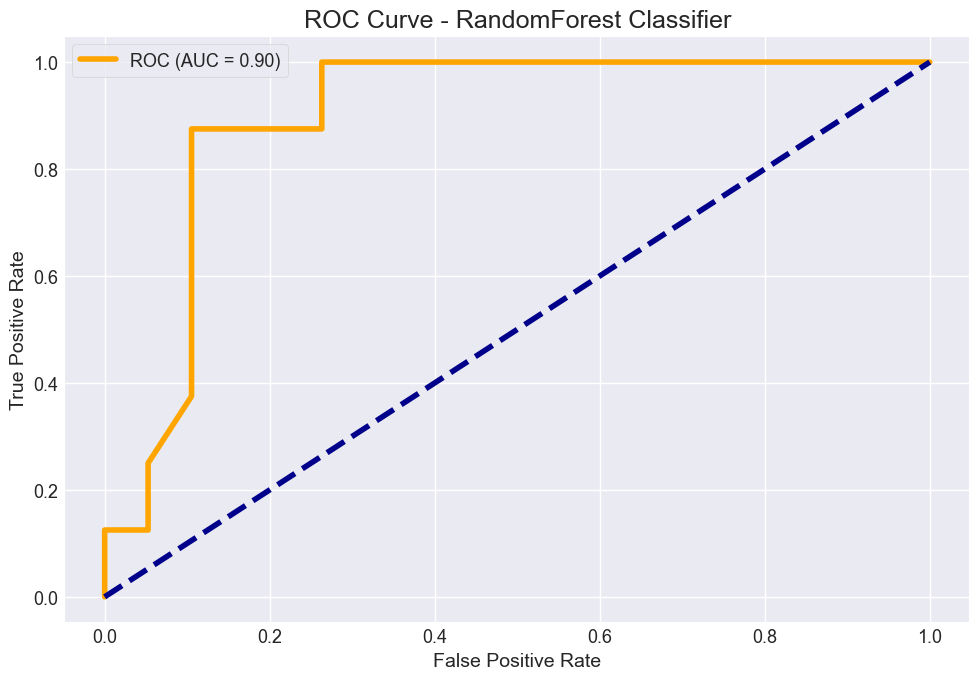

In [349]:
from sklearn.ensemble import RandomForestClassifier

# Init model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train & predict 
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred_rf))
print(f"Random Forest Classifier Accuracy: {accuracy_score(y_test, y_pred_rf)*100:.2f}%")

# ROC-AUC Curve
Y_test_probability_true = rf_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, Y_test_probability_true)
auc = roc_auc_score(y_test, Y_test_probability_true)

plt.figure(figsize=(10,7), tight_layout=True)
plt.plot(fpr, tpr, color='orange', label=f'ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForest Classifier')
plt.legend()
plt.show()

# Model 3: Support Vector Machines

              precision    recall  f1-score   support

           0       0.82      0.95      0.88        19
           1       0.80      0.50      0.62         8

    accuracy                           0.81        27
   macro avg       0.81      0.72      0.75        27
weighted avg       0.81      0.81      0.80        27

Support Vector Machine Accuracy:81.48%


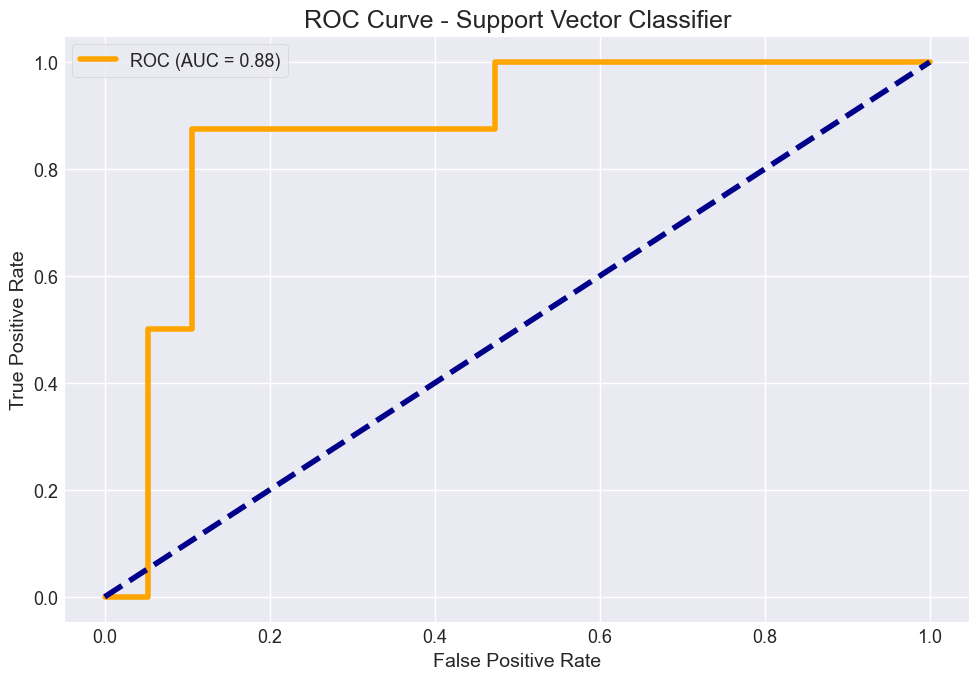

In [350]:
from sklearn.svm import SVC


svm_clf = SVC(kernel='linear', random_state=42, probability=True)

svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

print(classification_report(y_test, y_pred_svm))

print(f"Support Vector Machine Accuracy:{accuracy_score(y_test, y_pred_svm)*100:.2f}%")

# ROC-AUC Curve
Y_test_probability_true = svm_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, Y_test_probability_true)
auc = roc_auc_score(y_test, Y_test_probability_true)

plt.figure(figsize=(10,7), tight_layout=True)
plt.plot(fpr, tpr, color='orange', label=f'ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Support Vector Classifier')
plt.legend()
plt.show()